In [1]:
import os
os.environ['FOR_DISABLE_CONSOLE_CTRL_HANDLER'] = '1'

import random, statistics
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import dill, joblib

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torchvision.transforms import v2
from torch.utils.data import DataLoader
import torchinfo

from monai.losses.dice import DiceLoss, DiceFocalLoss, GeneralizedDiceFocalLoss
from monai.metrics import MeanIoU, SurfaceDiceMetric, DiceHelper # type:ignore
from schedulefree import AdamWScheduleFree
from came_pytorch import CAME
from madgrad import MADGRAD

from stuff.found.focal_tversky_loss import focal_tversky

from glio.train2 import *
from glio.train2.cbs_summary import Summary
from glio.visualize import vis_imshow, vis_imshow_grid, Visualizer
from glio.plot.figure import Figure, qimshow, qimshow_batch, qlinechart, qscatter, linechart
from glio.jupyter_tools import show_slices, show_slices_arr, clean_mem
from glio.torch_tools import area_around, one_hot_mask, summary, lr_finder, to_binary, count_parameters
from glio.python_tools import type_str, CacheRepeatIterator, get_all_files, get0, get1
from glio import nn as gnn
from glio.nn import conv, convt, linear, seq, block
from glio.data import DSToTarget
from glio.helpers import cnn_output_size, tcnn_output_size
from glio.loaders import nifti
from glio.transforms import fToChannels, fToChannelsFirst,fToChannelsLast, z_normalize, norm_to01
from glio.datasets.BRaTS2024_preloaded import get_ds_2d, get_ds_around, loader_2d, loader_around, loader_around_fix


In [2]:
TITLE = "BRATS2024 2D general"
bratstrain = get_ds_around(r"E:\dataset\BRaTS2024-GoAT\train hist.joblib")
bratstest = get_ds_around(r"E:\dataset\BRaTS2024-GoAT\test hist.joblib")

dstrain = DSToTarget()
dstest = DSToTarget()
dstrain.add_samples(bratstrain, loader_around_fix, None, get0, get1)
dstest.add_samples(bratstest, loader_around_fix, None, get0, get1)

color_legend = "\nчерный:нет;\nсиний:отёк;\nзелёный:некротическое ядро,\nкрасный:усиливающая опухоль"
cmp = ListedColormap(['black','red', 'green', 'blue'])
def plot_preds(learner:Learner, batch, softmax = True, unsqueeze = True):
    batch = list(batch)
    if unsqueeze:
        batch[0] = batch[0].unsqueeze(0)
        batch[1] = batch[1].unsqueeze(0)
    preds = learner.inference(batch[0].to(learner.device))
    batch[0][0] = torch.stack([norm_to01(i) for i in batch[0][0]])
    batch[0][:,3,0,0] = 1
    preds[0][3,0,0] = 1
    v = Visualizer()
    v.imshow_grid(batch[0][0][1::3], mode="bhw", label="вход:\nT1n, T1c, FLAIR, T2W")
    v.imshow(batch[1][0].argmax(0), mode="bhw", label = f"реальная карта:{color_legend}", cmap=cmp)
    if softmax:
        output = torch.stack([preds[0],preds[0],preds[0]], dim=1)
        output[:,0] *=  F.softmax(preds[0],0)
        v.imshow_grid(output, mode="bchw", label="сырой выход:\nнет, отёк,\nнекротическое ядро,\nусиливающая опухоль")
    else:
        v.imshow_grid(preds[0], mode="bchw", label="сырой выход:\nнет, отёк,\nнекротическое ядро,\nусиливающая опухоль")
    v.imshow(preds[0].argmax(0), mode="bhw", label=f"предсказанная карта:{color_legend}", cmap=cmp)
    v.imshow(preds[0].argmax(0) != batch[1][0].argmax(0), mode="bhw", label="ошибка", cmap='gray')
    imgs = torch.stack([batch[0][0],batch[0][0],batch[0][0]], dim=0)
    imgsreal = torch.stack([batch[0][0],batch[0][0],batch[0][0]], dim=0)
    apreds = preds[0].argmax(0)
    aptargets = batch[1][0].argmax(0)
    imgs[0] = torch.where(apreds == 1, imgs[0]*2, imgs[0]).clip(0,1)
    imgs[1] = torch.where(apreds == 2, imgs[1]*2, imgs[1]).clip(0,1)
    imgs[2] = torch.where(apreds == 3, imgs[2]*2, imgs[2]).clip(0,1)
    imgsreal[0] = torch.where(aptargets == 1, imgsreal[0]*2, imgsreal[0]).clip(0,1)
    imgsreal[1] = torch.where(aptargets == 2, imgsreal[1]*2, imgsreal[1]).clip(0,1)
    imgsreal[2] = torch.where(aptargets == 3, imgsreal[2]*2, imgsreal[2]).clip(0,1)
    v.imshow_grid(imgs.swapaxes(0,1), mode="bchw", label=f"предсказанная карта:{color_legend}")
    v.imshow(imgs[:,0], label=f"предсказанная карта:{color_legend}")
    v.imshow(imgsreal[:,0], label=f"реальная карта:{color_legend}")
    v.show(figsize=(24, 24), nrows=1, fontsize=12)

In [3]:
show_slices(dstrain[0][0])

interactive(children=(Checkbox(value=False, description='color'), IntSlider(value=5, description='s0', max=11)…

<function glio.jupyter_tools.show_slices.<locals>.f(color, **kwargs)>

# Base model

In [17]:
class UNetBase(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = conv(12, 64, 3, 2, 1, act=nn.ReLU())
        self.c2 = conv(64, 128, 3, 2, 1, act=nn.ReLU())
        self.c3 = conv(128, 192, 3, 2, 1, act=nn.ReLU())
        self.c4 = conv(192, 256, 3, 2, 1, act=nn.ReLU())

        self.tc1 = convt(256, 192, 2, 2, act=nn.ReLU())
        self.tc2 = gnn.SignalConcat(convt(384, 128, 2, 2, act=nn.ReLU()))
        self.tc3 = gnn.SignalConcat(convt(256, 64, 2, 2, act=nn.ReLU()))
        self.tc4 = gnn.SignalConcat(convt(128, 4, 2, 2))



    def forward(self, x1):
        x2 = self.c1(x1)
        x3 = self.c2(x2)
        x4 = self.c3(x3)
        x = self.c4(x4)

        x = self.tc1(x)
        x = self.tc2(x, x4)
        x = self.tc3(x, x3)
        x = self.tc4(x, x2)
        return x

torchinfo.summary(UNetBase(), (8, 12, 96, 96), depth=10, col_names=["input_size", "output_size", "num_params", "params_percent", "kernel_size", "mult_adds", "trainable"], col_width = 20)

Layer (type:depth-idx)                        Input Shape          Output Shape         Param #              Param %              Kernel Shape         Mult-Adds            Trainable
UNetBase                                      [8, 12, 96, 96]      [8, 4, 96, 96]       --                        --              --                   --                   True
├─Sequential: 1-1                             [8, 12, 96, 96]      [8, 64, 48, 48]      --                        --              --                   --                   True
│    └─Conv2d: 2-1                            [8, 12, 96, 96]      [8, 64, 48, 48]      6,976                  0.58%              [3, 3]               128,581,632          True
│    └─ReLU: 2-2                              [8, 64, 48, 48]      [8, 64, 48, 48]      --                        --              --                   --                   --
├─Sequential: 1-2                             [8, 64, 48, 48]      [8, 128, 24, 24]     --                      

[-0.002, 0.004, 0.002, 0.004, -0.002, -0.0, -0.003, 0.001], [1.004, 1.061, 1.035, 1.049, 0.996, 1.029, 1.012, 1.036], [11, 11, 11, 11, 11, 11, 11, 11]             


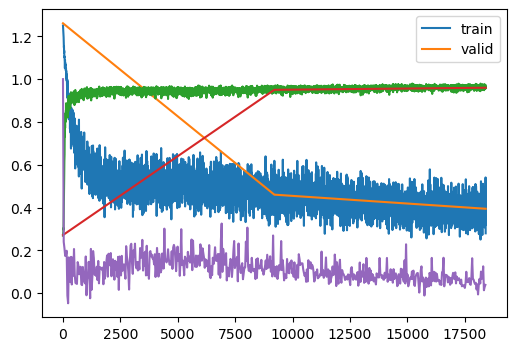

test loss: min: 0.3947; max: 1.2610; last: 0.3947
test accuracy: min: 0.2718; max: 0.9599; last: 0.9599
test dice: min: nan; max: nan; last: nan
test iou: min: 0.1653; max: 0.9307; last: 0.9145
test precision: min: 0.2761; max: 0.9566; last: 0.9532
test recall: min: 0.2761; max: 0.9566; last: 0.9532
test f1: min: 0.2730; max: 0.9573; last: 0.9573
test average precision: min: 0.2511; max: 0.4147; last: 0.4147
test roc auc: min: 0.4887; max: 0.7697; last: 0.7697
update mean: min: -0.0000; max: 0.0000; last: -0.0000
update std: min: 0.0000; max: 0.0018; last: 0.0000
update var: min: 0.0000; max: 0.0000; last: 0.0000
update min: min: -0.0643; max: -0.0000; last: -0.0000
update max: min: 0.0000; max: 0.0634; last: 0.0000
update angle: min: 0.0000; max: 0.0089; last: 0.0000
update cosine: min: 1.0000; max: 1.0000; last: 1.0000
grad mean: min: -0.0004; max: 0.0004; last: 0.0000
grad std: min: 0.0001; max: 0.0045; last: 0.0005
grad var: min: 0.0000; max: 0.0000; last: 0.0000
grad min: min: -0.

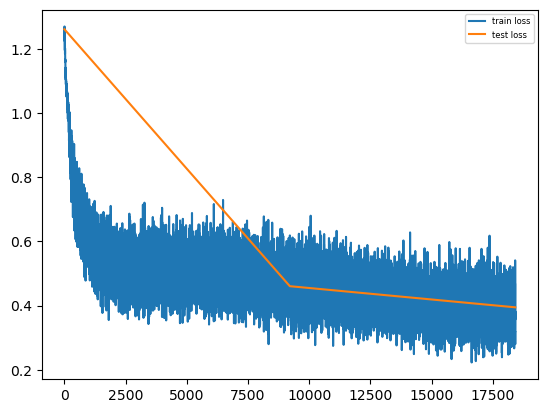

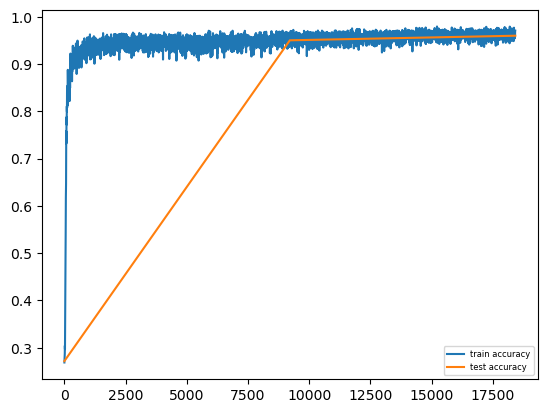

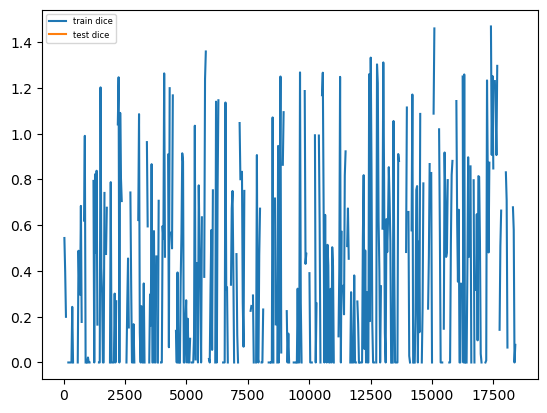

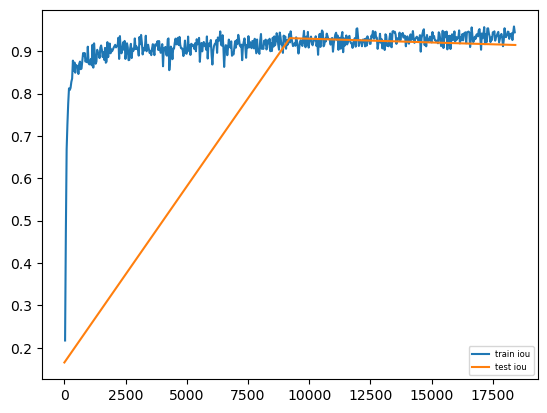

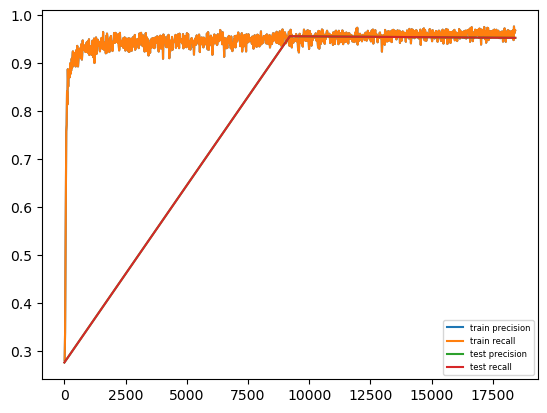

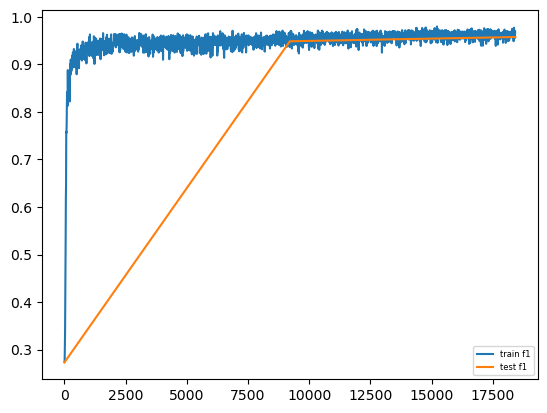

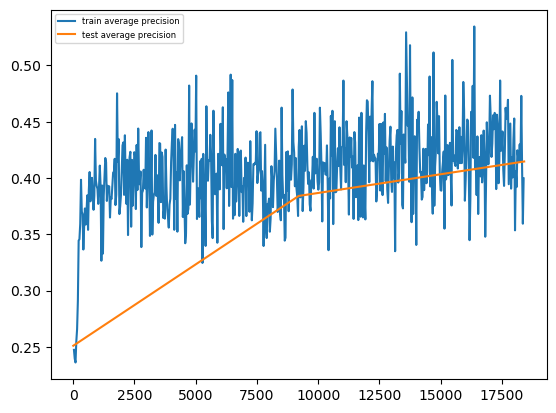

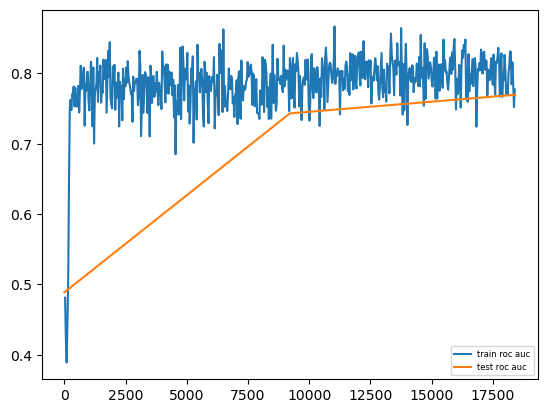

IndexError: invalid index to scalar variable.

In [5]:
MODEL = UNetBase()
NAME = f"{MODEL.__class__.__name__}"
LR = 1e-2
BATCH_SIZE = 32
N_EPOCHS = 2

torch.backends.cudnn.benchmark = True
torch.jit.enable_onednn_fusion(True)

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dltrain = DataLoader(dstrain, BATCH_SIZE, shuffle=True)
dltest = DataLoader(dstest, BATCH_SIZE)

OPT = optim.RAdam(MODEL.parameters(), lr=LR, eps=1e-6)
LOSS_FN = GeneralizedDiceFocalLoss(softmax=True)
SCHED = lr_scheduler.OneCycleLR(OPT, max_lr=LR, steps_per_epoch=len(dltrain), epochs=N_EPOCHS)

clean_mem()
MODEL = gnn.LSUV(MODEL, dltrain, max_iter=10)

LEARNER_NAME = f"{NAME} RAdam 1e-2 32"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = (Metric_Loss(), # Log_GradHistorgram(16), Log_SignalHistorgram(16),
                         Log_UpdateDist(32), Log_GradDist(32), Log_GradUpdateAngle(32), Log_ParamDist(32), Log_ParamPath(32, 32), 
                         Log_Time(), Save_Best(TITLE), Save_Last(TITLE), Log_LR(), Summary(), Accelerate("no"),
                         Metric_Accuracy(True, True, False, name = 'accuracy', step=4),
                         MONAI_IoU(4, True, True, step=32, name='iou'),
                         Torcheval_Precision(4, True, True, step=16),
                         Torcheval_Recall(4, True, True, step=16),
                         Torcheval_Dice(4, True, True, step=8, name='f1'),
                         Torcheval_AURPC(4, True, step=32),
                         Torcheval_AUROC(4, True, step=32),
                         FastProgressBar(plot=True, step_batch=32, metrics=
                                         ["train loss", "test loss",
                                          "train accuracy", "test accuracy",
                                          "grad-update cosine",
                                          ]),
                         ),
                  loss_fn=LOSS_FN,
                  optimizer=OPT,
                  scheduler=SCHED,)
learner.fit(N_EPOCHS, dltrain, dltest)
plt.show()
learner.logger.plot_all("loss",show=True)
learner.logger.plot_all("accuracy",show=True)
learner.logger.plot_all("iou",show=True)
learner.logger.plot_all(["train precision", "test precision", "recall"],show=True)
learner.logger.plot_all("f1",show=True)
learner.logger.plot_all("average precision",show=True)
learner.logger.plot_all("roc auc",show=True)
learner.logger.path("update path mean",show=True)
learner.logger.path("update path l2",show=True)
plot_preds(learner, dstrain[200])
plot_preds(learner, dstest[500])
plot_preds(learner, dstrain[1650])
plot_preds(learner, dstest[1650])

# Base UNet - Reducing to 3x3

In [26]:
class UNetBase2(nn.Module):
    def __init__(self):
        super().__init__()
        self.c1 = conv(12, 64, 3, 2, 1, act=nn.ReLU())
        self.c2 = conv(64, 128, 3, 2, 1, act=nn.ReLU())
        self.c3 = conv(128, 192, 3, 2, 1, act=nn.ReLU())
        self.c4 = conv(192, 256, 3, 2, 1, act=nn.ReLU())
        self.c5 = conv(256, 512, 3, 2, 1, act=nn.ReLU())

        self.tc1 = convt(512, 384, 2, 2, act=nn.ReLU())
        self.tc2 = gnn.SignalConcat(convt(640, 384, 2, 2, act=nn.ReLU()))
        self.tc3 = gnn.SignalConcat(convt(576, 256, 2, 2, act=nn.ReLU()))
        self.tc4 = gnn.SignalConcat(convt(384, 128, 2, 2, act=nn.ReLU()))
        self.tc5 = gnn.SignalConcat(convt(192, 4, 2, 2))



    def forward(self, x1):
        x2 = self.c1(x1)
        x3 = self.c2(x2)
        x4 = self.c3(x3)
        x5 = self.c4(x4)
        x = self.c5(x5)

        x = self.tc1(x)
        x = self.tc2(x, x5)
        x = self.tc3(x, x4)
        x = self.tc4(x, x3)
        x = self.tc5(x, x2)
        return x

torchinfo.summary(UNetBase2(), (8, 12, 96, 96), depth=10, col_names=["input_size", "output_size", "num_params", "params_percent", "kernel_size", "mult_adds", "trainable"], col_width = 20)
#summary(UNetBase2(), (8, 12, 96, 96))

Layer (type:depth-idx)                        Input Shape          Output Shape         Param #              Param %              Kernel Shape         Mult-Adds            Trainable
UNetBase2                                     [8, 12, 96, 96]      [8, 4, 96, 96]       --                        --              --                   --                   True
├─Sequential: 1-1                             [8, 12, 96, 96]      [8, 64, 48, 48]      --                        --              --                   --                   True
│    └─Conv2d: 2-1                            [8, 12, 96, 96]      [8, 64, 48, 48]      6,976                  0.16%              [3, 3]               128,581,632          True
│    └─ReLU: 2-2                              [8, 64, 48, 48]      [8, 64, 48, 48]      --                        --              --                   --                   --
├─Sequential: 1-2                             [8, 64, 48, 48]      [8, 128, 24, 24]     --                      

[0.003, 0.001, 0.008, 0.003, -0.004, 0.001, -0.001, 0.0, -0.001, 0.009], [1.012, 1.105, 1.044, 1.106, 1.039, 1.068, 1.044, 1.038, 1.087, 1.043], [11, 11, 11, 11, 11, 11, 11, 11, 11, 11]            


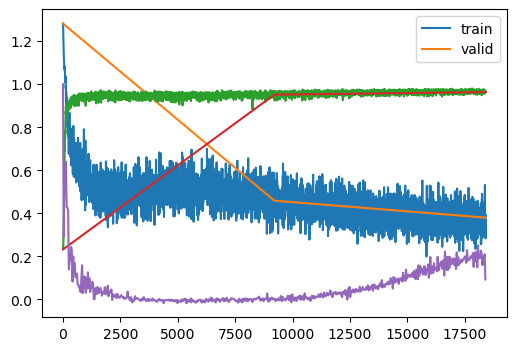

test loss: min: 0.3802; max: 1.2821; last: 0.3802
test accuracy: min: 0.2324; max: 0.9636; last: 0.9636
test iou: min: 0.1487; max: 0.9290; last: 0.9290
test precision: min: 0.2329; max: 0.9631; last: 0.9631
test recall: min: 0.2329; max: 0.9631; last: 0.9631
test f1: min: 0.2344; max: 0.9675; last: 0.9675
test average precision: min: 0.2518; max: 0.3742; last: 0.3742
test roc auc: min: 0.4973; max: 0.7754; last: 0.7754
update mean: min: -0.0000; max: 0.0000; last: -0.0000
update std: min: 0.0000; max: 0.0014; last: 0.0000
update var: min: 0.0000; max: 0.0000; last: 0.0000
update min: min: -0.0721; max: -0.0000; last: -0.0000
update max: min: 0.0000; max: 0.0740; last: 0.0000
update angle: min: 0.0000; max: 0.0095; last: 0.0000
update cosine: min: 1.0000; max: 1.0000; last: 1.0000
grad mean: min: -0.0001; max: 0.0001; last: -0.0000
grad std: min: 0.0001; max: 0.0012; last: 0.0003
grad var: min: 0.0000; max: 0.0000; last: 0.0000
grad min: min: -0.7758; max: -0.0108; last: -0.1920
grad m

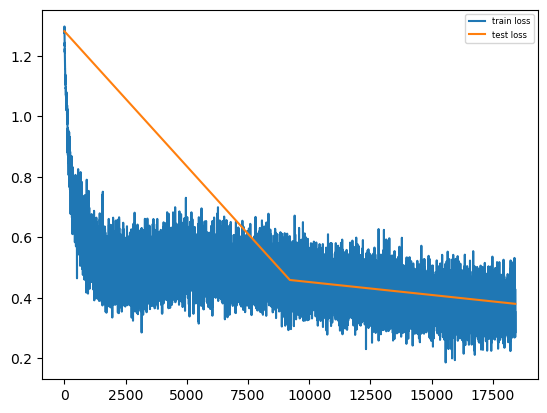

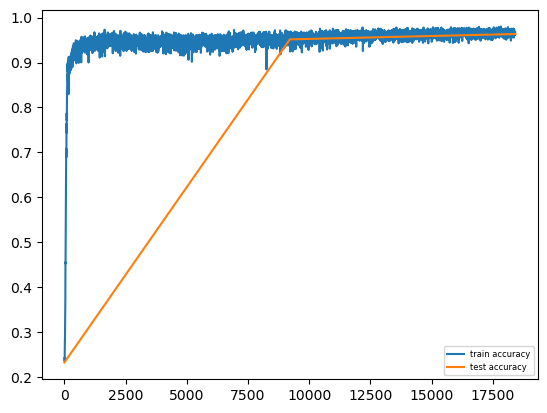

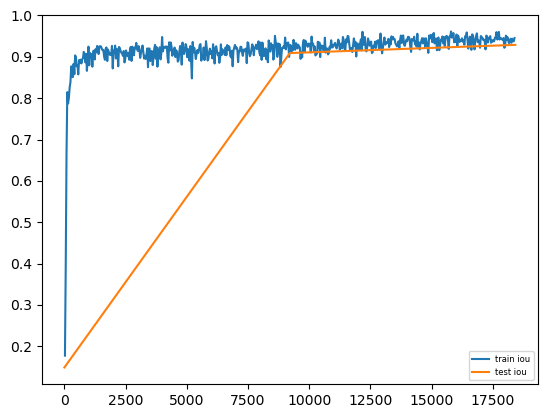

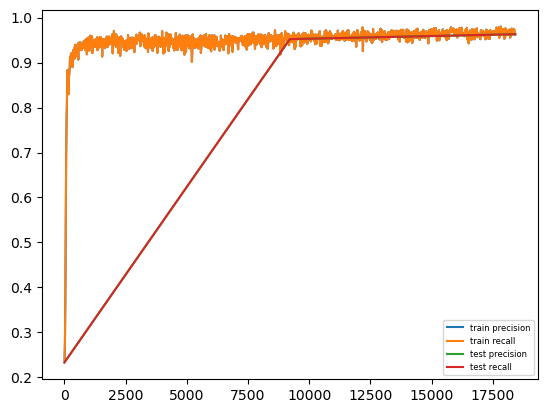

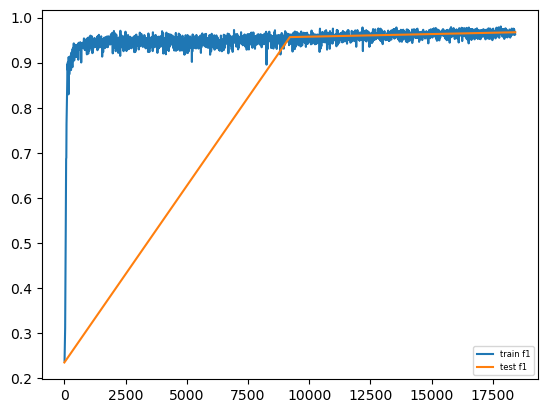

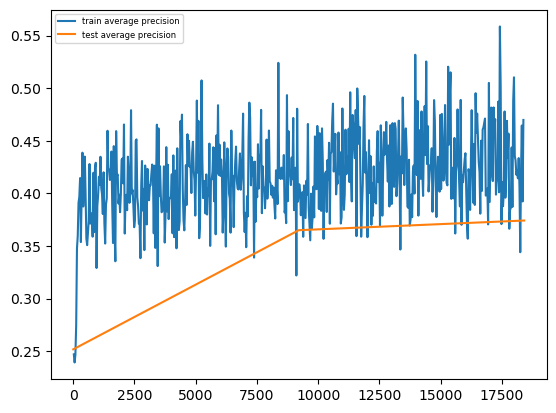

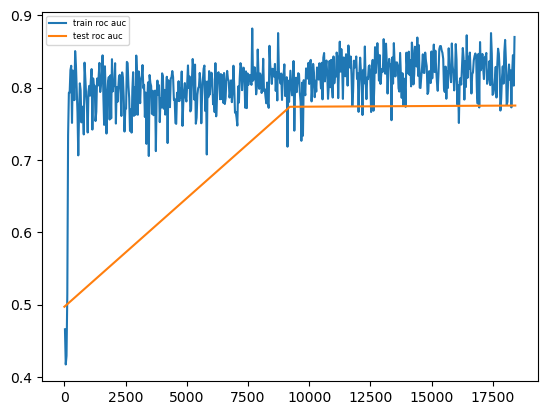

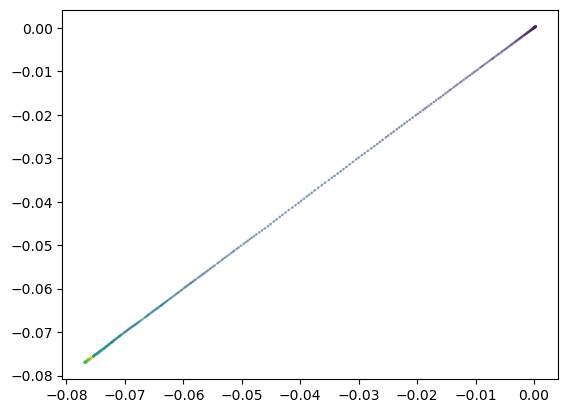

KeyError: 'update path l2'

In [28]:
MODEL = UNetBase2()
NAME = f"{MODEL.__class__.__name__}"
LR = 1e-2
BATCH_SIZE = 32
N_EPOCHS = 2

torch.backends.cudnn.benchmark = True
torch.jit.enable_onednn_fusion(True)

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dltrain = DataLoader(dstrain, BATCH_SIZE, shuffle=True)
dltest = DataLoader(dstest, BATCH_SIZE)

OPT = optim.RAdam(MODEL.parameters(), lr=LR, eps=1e-6)
LOSS_FN = GeneralizedDiceFocalLoss(softmax=True)
SCHED = lr_scheduler.OneCycleLR(OPT, max_lr=LR, steps_per_epoch=len(dltrain), epochs=N_EPOCHS)

clean_mem()
MODEL = gnn.LSUV(MODEL, dltrain, max_iter=10)

LEARNER_NAME = f"{NAME} RAdam 1e-2 32 GDiceFocalLoss"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = (Metric_Loss(), # Log_GradHistorgram(16), Log_SignalHistorgram(16),
                         Log_UpdateDist(32), Log_GradDist(32), Log_GradUpdateAngle(32), Log_ParamDist(32), Log_ParamPath(32, 32), 
                         Log_LastGradsAngle(32), Log_LastUpdatesAngle(32),
                         Log_Time(), Save_Best(TITLE), Save_Last(TITLE), Log_LR(), Summary(), Accelerate("no"),
                         Metric_Accuracy(True, True, False, name = 'accuracy', step=4),
                         MONAI_IoU(4, True, True, step=32, name='iou'),
                         Torcheval_Precision(4, True, True, step=16),
                         Torcheval_Recall(4, True, True, step=16),
                         Torcheval_Dice(4, True, True, step=8, name='f1'),
                         Torcheval_AURPC(4, True, step=32),
                         Torcheval_AUROC(4, True, step=32),
                         FastProgressBar(plot=True, step_batch=32, metrics=
                                         ["train loss", "test loss",
                                          "train accuracy", "test accuracy",
                                          "grad-update cosine",
                                          ]),
                         ),
                  loss_fn=LOSS_FN,
                  optimizer=OPT,
                  scheduler=SCHED,)
learner.fit(N_EPOCHS, dltrain, dltest)
plt.show()
learner.logger.plot_all("loss",show=True)
learner.logger.plot_all("accuracy",show=True)
learner.logger.plot_all("iou",show=True)
learner.logger.plot_all(["train precision", "test precision", "recall"],show=True)
learner.logger.plot_all("f1",show=True)
learner.logger.plot_all("average precision",show=True)
learner.logger.plot_all("roc auc",show=True)
learner.logger.path("update path mean",show=True)
learner.logger.path("update path L2",show=True)
plot_preds(learner, dstrain[200])
plot_preds(learner, dstest[500])
plot_preds(learner, dstrain[1650])
plot_preds(learner, dstest[1650])

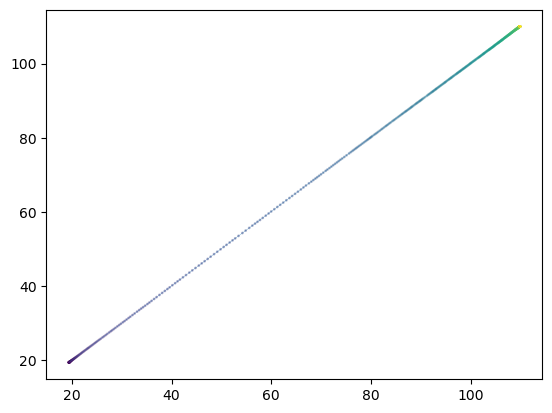

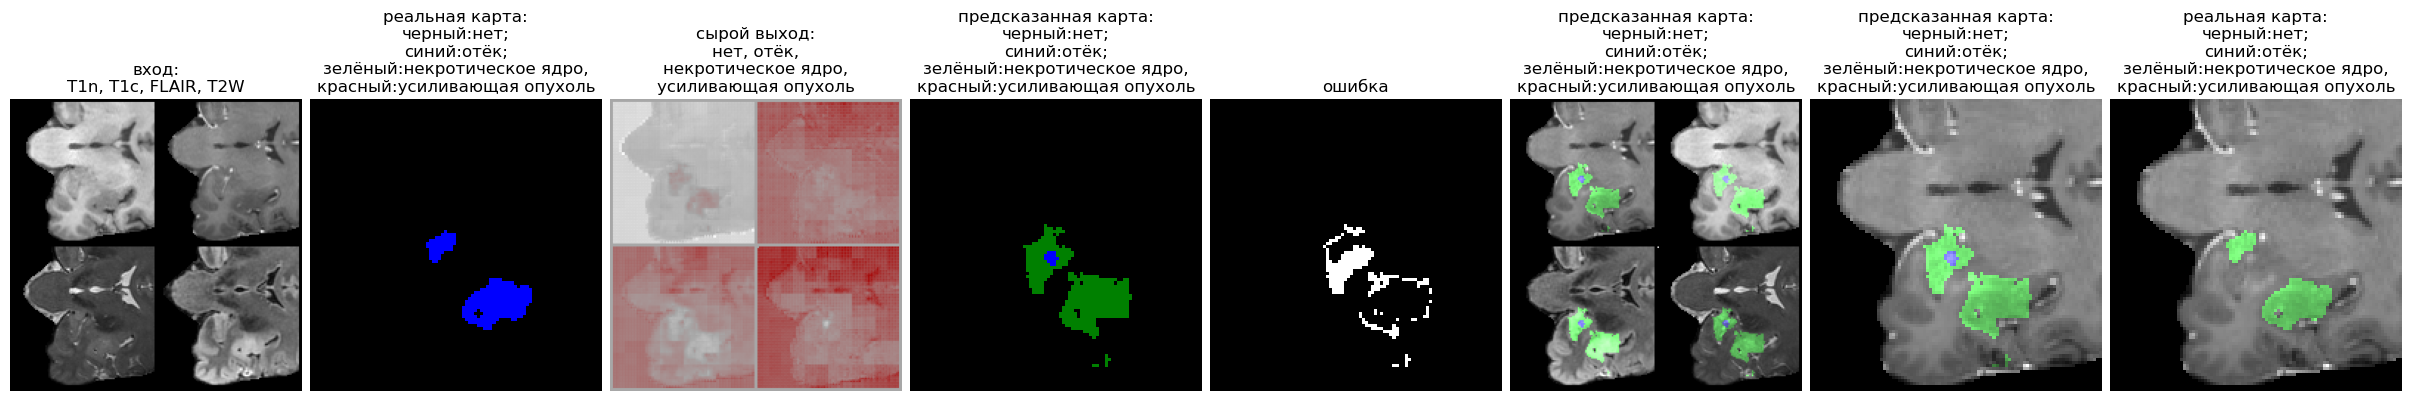

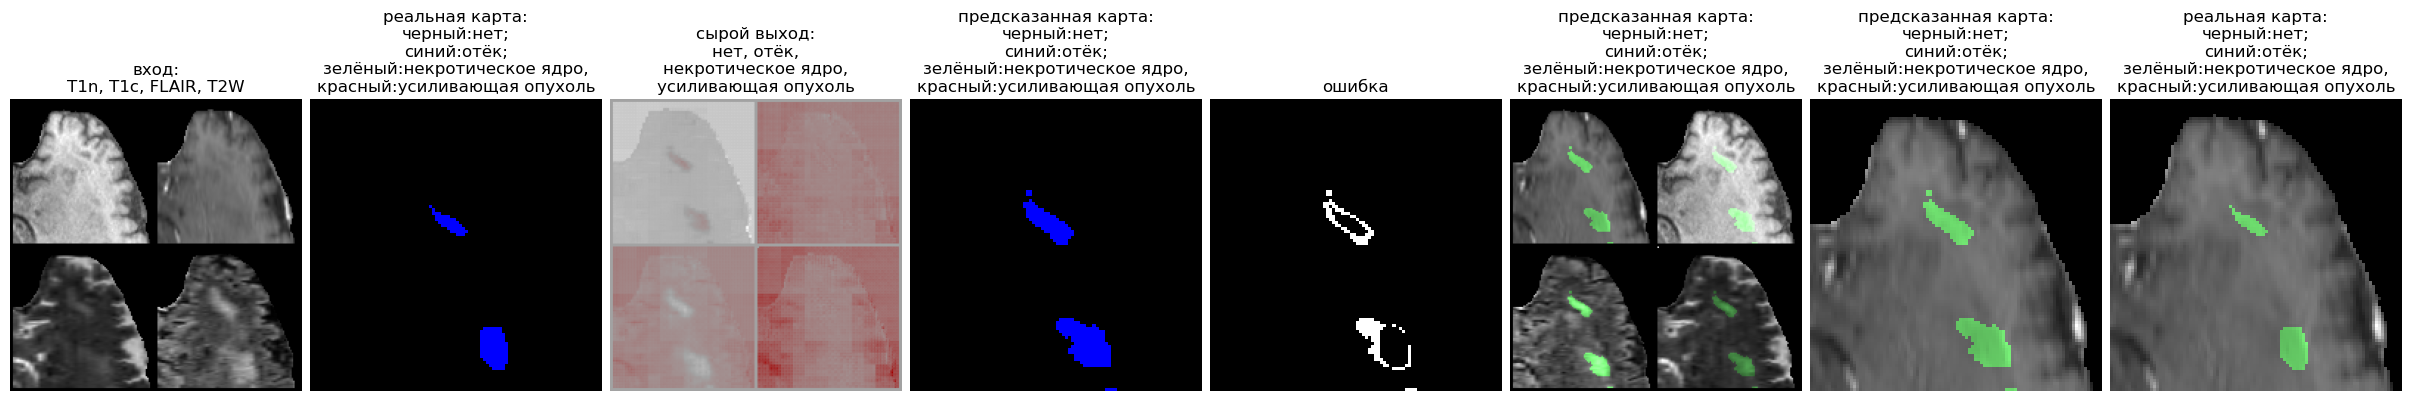

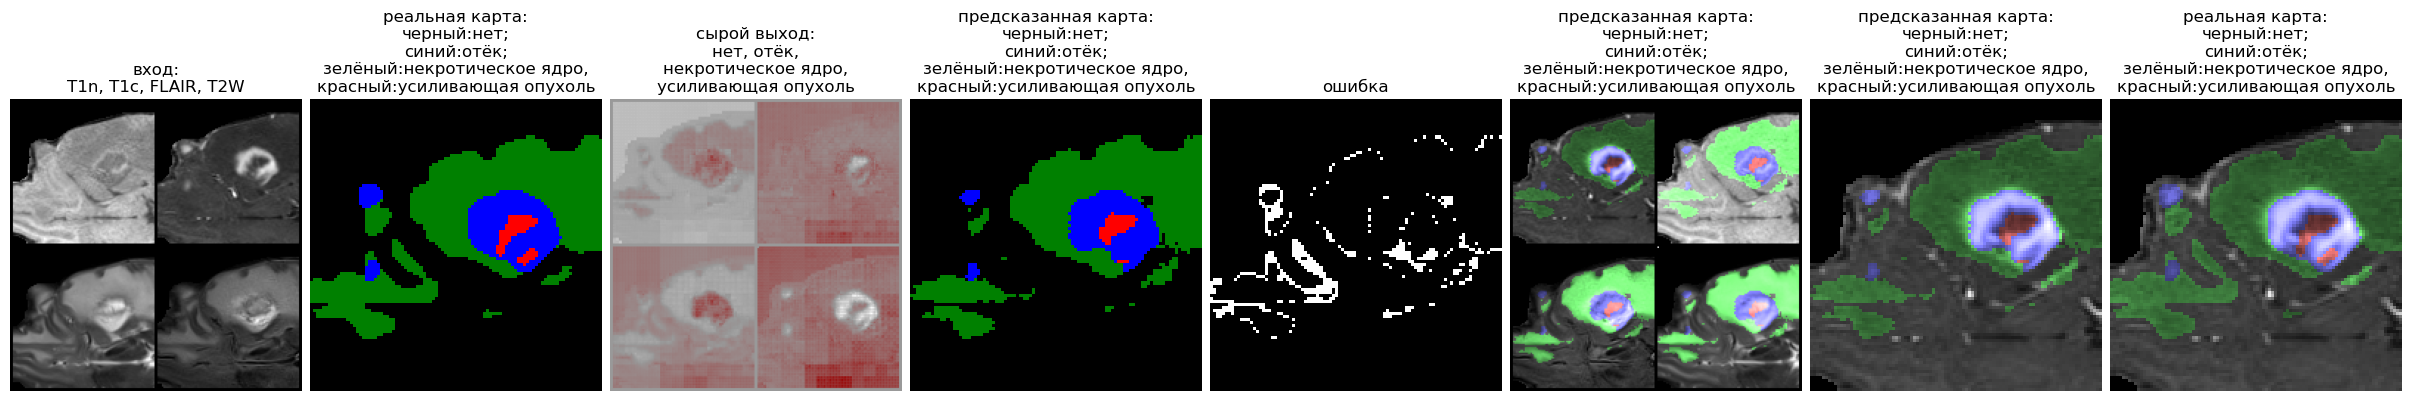

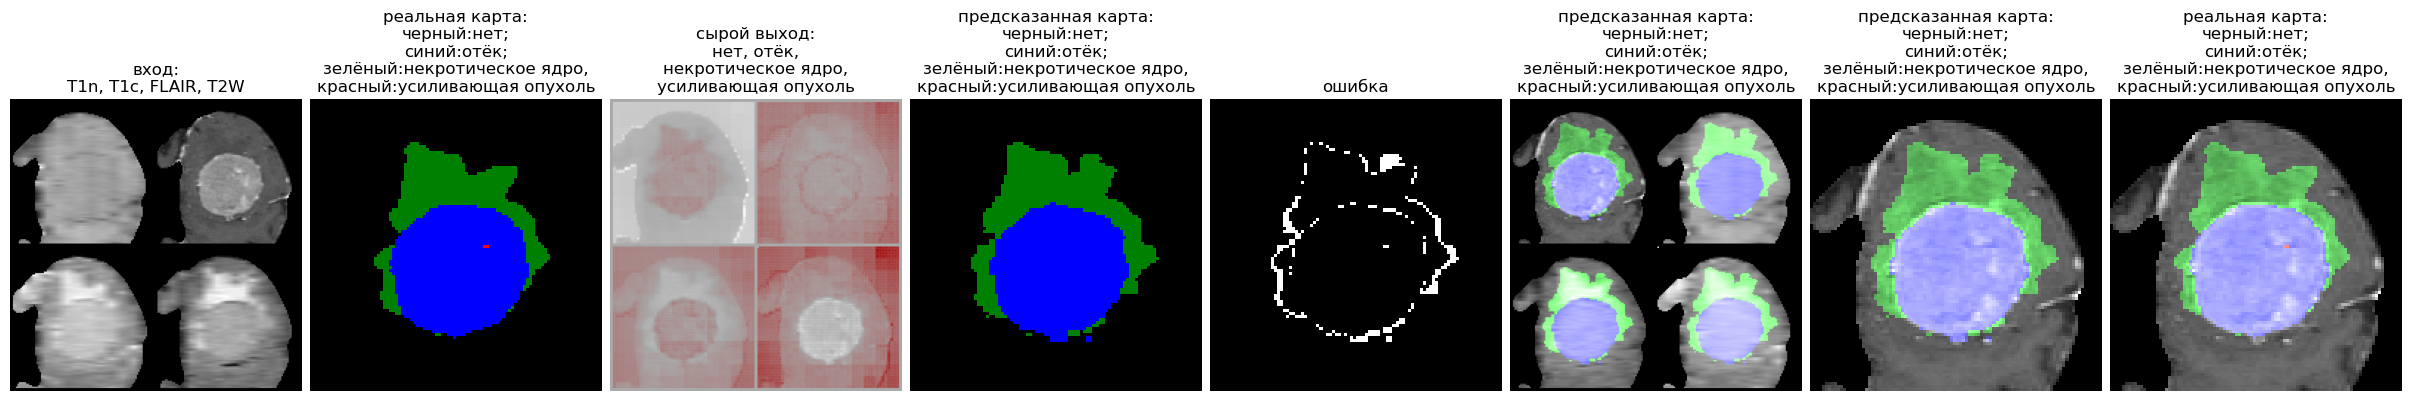

In [30]:
learner.logger.path("update path L2",show=True)
plot_preds(learner, dstrain[200])
plot_preds(learner, dstest[500])
plot_preds(learner, dstrain[1650])
plot_preds(learner, dstest[1650])